In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from geoscripts import gchemplots as gp
from geoscripts import gchemcalc as gc

In [22]:
# New Data
data = pd.read_csv('processed/data.csv',index_col=0)

# Filter for J
filter_period = (data['Period']=='Jurassic')|(data['Period']=='Jurassic?')
data_filt = data[filter_period]
print(data_filt.index)

Index(['G22019', 'G22020', 'G22032A', 'G22033', 'G22034', 'G22035', 'G22036A',
       'G22037', 'G22038', 'G22039', 'G22041A', 'G22041C', 'G22042', 'G22044',
       'G22045', 'G22046C', 'G22049', 'G22051', 'G22053', 'G22063', 'G22065',
       'G22066', 'G22067', 'G22068A', 'G22068B', 'G22068C', 'G22069', 'G22076',
       'G22081', 'G22091', 'G22092', 'G22094', 'G22096', 'G22108A', 'G22109',
       'G22110', 'G22111', 'G22114', 'G22118', 'G22119', 'G22125', 'G22126',
       'G22129', 'G22130', 'G22131', 'G22141', 'C17069B', '100311-3A'],
      dtype='object')


In [23]:
# Groups
khaishi_core_smps = ['G22034','G22035','G22036A','G22037','G22038','G22039']
data_filt.loc[khaishi_core_smps,'S_Domain'] = 'Khaishi Core'

limb_condition = (~data_filt.index.isin(khaishi_core_smps)) & (data_filt['S_Domain'] == 'Khaishi')
data_filt.loc[limb_condition,'S_Domain'] = 'Khaishi Limbs'

group_dict = {'Khaishi Core':'Khaishi Core','Khaishi Limbs':'Khaishi Limbs','Idliani':'Idliani','Jvari':'Jvari','Lentekhi':'Lentekhi/Panaga','Mazashi':'Mazashi','Panaga':'Lentekhi/Panaga',
              'Tsageri-Khvamli':'Tsageri-Khvamli','Dzirula':np.nan,'Pasanauri':np.nan,'Dizi':np.nan,'Cretaceous Intrusive':np.nan}

chem_group = [group_dict[x] for x in data_filt['S_Domain']]

groups = data_filt.groupby(chem_group,sort=False)

color_dict = {'Khaishi Core':'#88CCEE','Khaishi Limbs':'#44AA99','Idliani':'#117733','Jvari':'#999933','Lentekhi/Panaga':'#AA4499','Mazashi':'#882255','Tsageri-Khvamli':'#CC6677',
              np.nan:'#DDDDDD'}

axes_dict = {'Khaishi Core':(0,0),'Khaishi Limbs':(0,0),'Idliani':(1,0),'Jvari':(2,0),'Lentekhi/Panaga':(0,1),'Mazashi':(1,1),'Tsageri-Khvamli':(2,1)}

In [24]:
# Old Data
gale = pd.read_csv('processed/data_gale.csv')

cbab = pd.read_excel('published/Vasey_CaucArc_TableS4.xlsx',header=1)
spreading_cond = cbab['Region'].isin(['Okinawa Trough','Bransfield Strait','Tyrrhenian Sea'])
cbab_spread = cbab[spreading_cond]

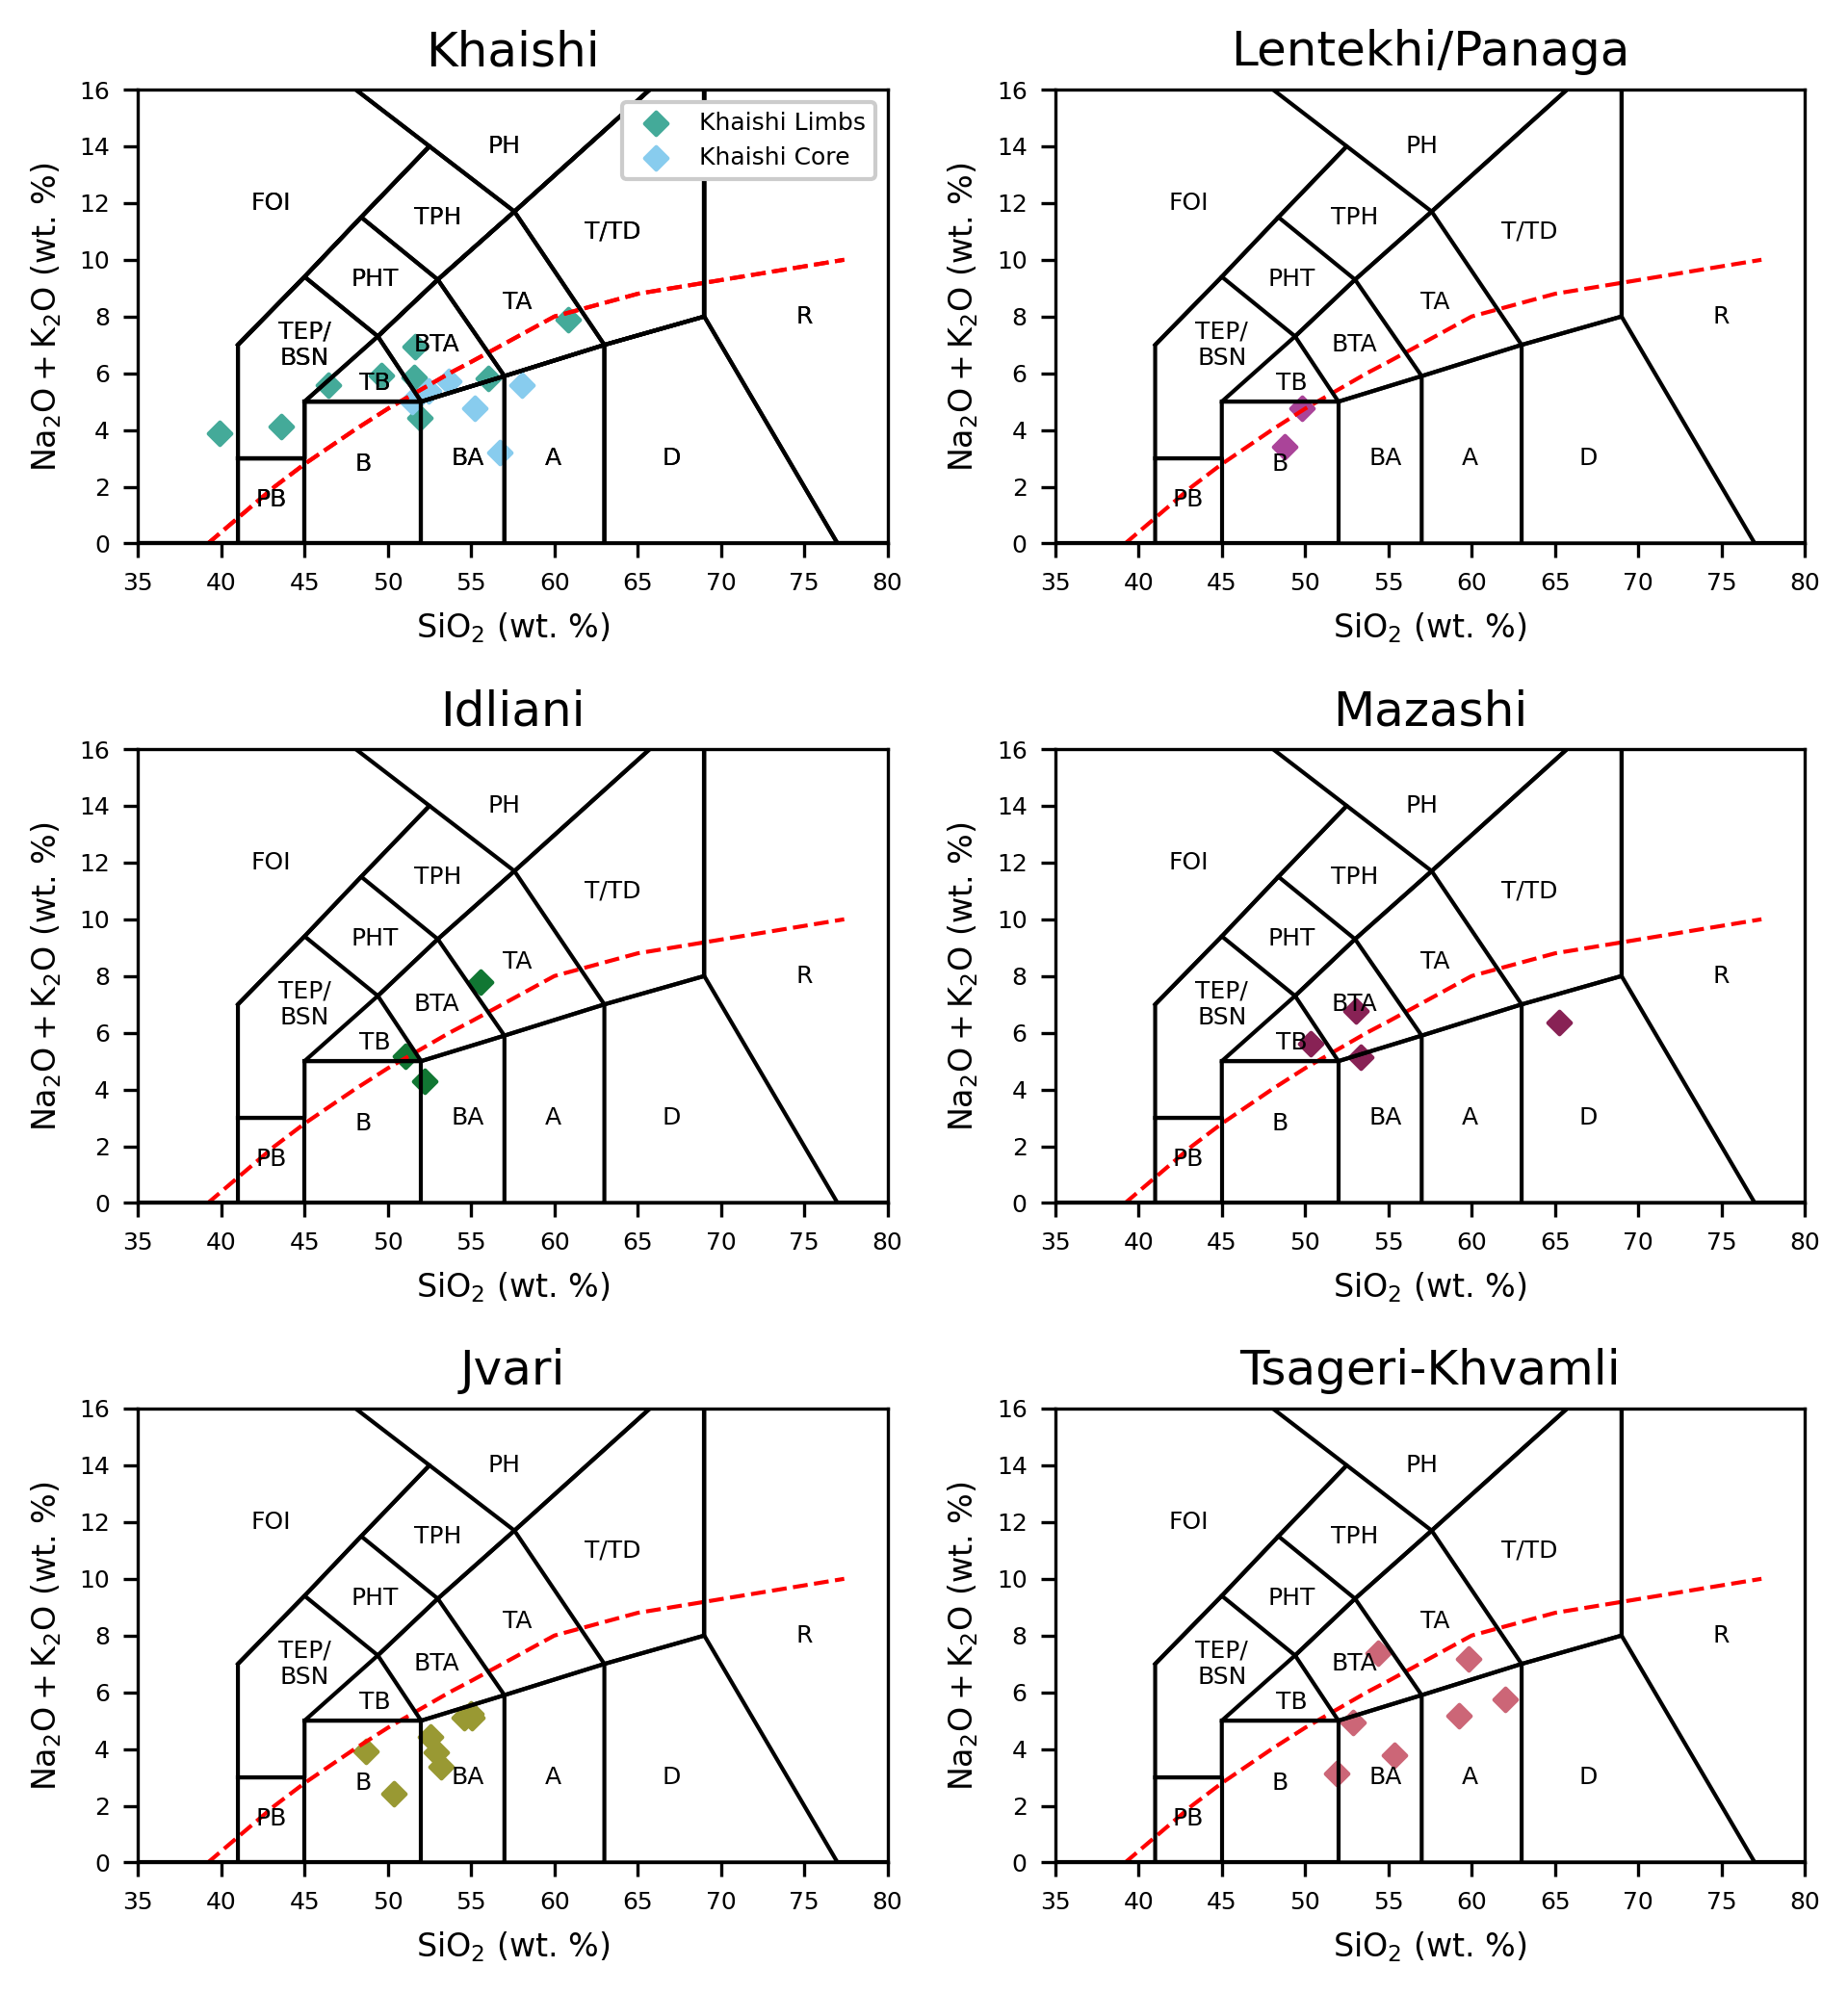

In [39]:
# TAS
fig,axs = plt.subplots(3,2,dpi=300,figsize=(6.5,7))

for k, group in groups:
    ax = axs[axes_dict[k]]
    color = color_dict[k]
    SiO2,Na2O,K2O = group[['SiO2','Na2O','K2O']].T.values
    gp.TASsm(SiO2,Na2O,K2O,label=k,ax=ax,color=color,first=[])
    ax.set_title(k)
axs[0,0].set_title('Khaishi')
axs[0,0].legend(fontsize=6,loc='upper right',frameon=True,framealpha=1,facecolor='white')

plt.tight_layout()

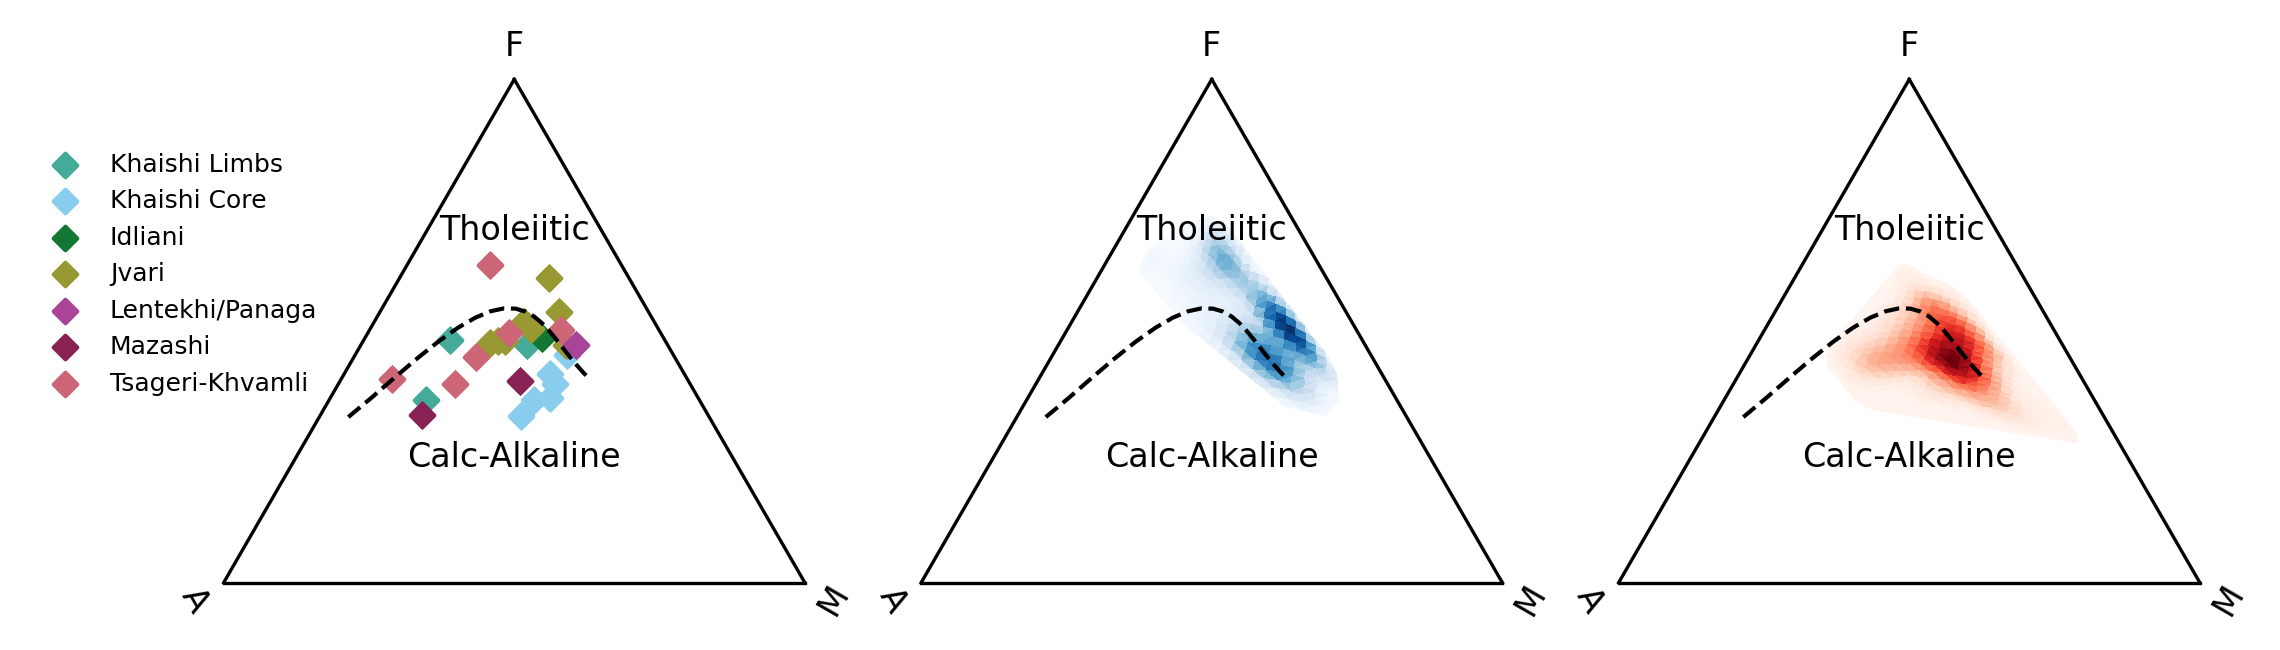

In [26]:
# AFM
fig,axs = plt.subplots(1,3,figsize=(8.5,11),dpi=300,subplot_kw={'projection':'ternary'})

first = []
for k,group in groups:
    group_sub = gc.classifyAlkaline(group)
    group_filt = group[group_sub]

    gp.afm(Na2O=group_filt['Na2O'],K2O=group_filt['K2O'],FeOt=group_filt['FeO*'],MgO=group_filt['MgO'],ax=axs[0],scatter=True,
       density=False,scatter_kwargs={'color':color_dict[k],'label':k},first=first)

gale_sub = gc.classifyAlkaline(gale)
gale_filt = gale[gale_sub]

gp.afm(Na2O=gale_filt['Na2O'],K2O=gale_filt['K2O'],FeOt=gale_filt['FeOt'],MgO=gale_filt['MgO'],ax=axs[1],scatter=False,
       density=True,first=[],density_kwargs={'cmap':'Blues'})

cbab_sub = gc.classifyAlkaline(cbab_spread)
cbab_filt = cbab_spread[cbab_sub]

gp.afm(Na2O=cbab_filt['Na2O'],K2O=cbab_filt['K2O'],FeOt=cbab_filt['FeOt'],MgO=cbab_filt['MgO'],ax=axs[2],scatter=False,
       density=True,first=[],density_kwargs={'cmap':'Reds'})

axs[0].legend(fontsize=6,loc='best',bbox_to_anchor=(0.2,0.9))